In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from runs import find_runs  # noqa: E402

### Load data and calculate error

In [8]:
def load_data(runs_dir: pathlib.Path) -> pd.DataFrame:
    """Load the data from the runs in the given directory.
    Calculate the position error between timestep 0 and 2000

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {} # Raw data: {column: {grid_spacing: error_value}}

    for run_path in runs:

        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file) 

        # Generate descriptive column name
        column_name = {
            "nearest-neighbor": "NN",
            "rbf-pum-direct": "RBF",
        }[parameters["mapping"]]

        if parameters["mapping"] == "rbf-pum-direct":
            column_name += (
                "_"
                + {
                    "compact-polynomial-c0": "CP0",
                    "compact-polynomial-c2": "CP2",
                    "compact-polynomial-c4": "CP4",
                    "compact-polynomial-c6": "CP6",
                    "compact-polynomial-c8": "CP8",
                }[parameters["basis_function"]]
            )
            column_name += f"_{parameters['support_radius']}"

        # Calculate grid spacing from refinement level
        grid_spacing = 1 / 2 ** parameters["refinement"]

        # Calculate position error
        try:
            file_name_begin = f"refinement-{parameters["refinement"]}_particles_000000.pvtu"
            file_name_end = f"refinement-{parameters["refinement"]}_particles_002000.pvtu"
            
            mesh_begin = pv.read(run_path / "solution" / file_name_begin)
            mesh_end = pv.read(run_path / "solution" / file_name_end)

            mesh_end["error"] = np.linalg.norm(mesh_begin.points - mesh_end.points, axis=1)

            mean_error = mesh_end["error"].mean()
        
        except FileNotFoundError:
            mean_error = np.nan

        # Insert error into data dict
        if column_name not in data:
            data[column_name] = {}
        data[column_name][grid_spacing] = mean_error

    # Convert data dict to pandas DataFrame
    return pd.DataFrame(data).sort_index(axis=0, ascending=False).sort_index(axis=1)

df = load_data(working_dir.parent / "runs" / "euler_explicit")
df

,NN,RBF_CP0_0.5,RBF_CP4_0.5,RBF_CP8_0.5
0.250000,0.066524,0.063438,0.064500,0.062133
0.125000,0.063289,0.061410,0.061163,0.060138
0.062500,0.036413,0.035978,0.035956,0.035378
0.031250,0.027446,0.027506,0.027578,0.027578
0.015625,0.026066,0.026725,0.026725,0.026725
0.007812,0.026547,0.026950,0.026950,0.026950


### Plot the error

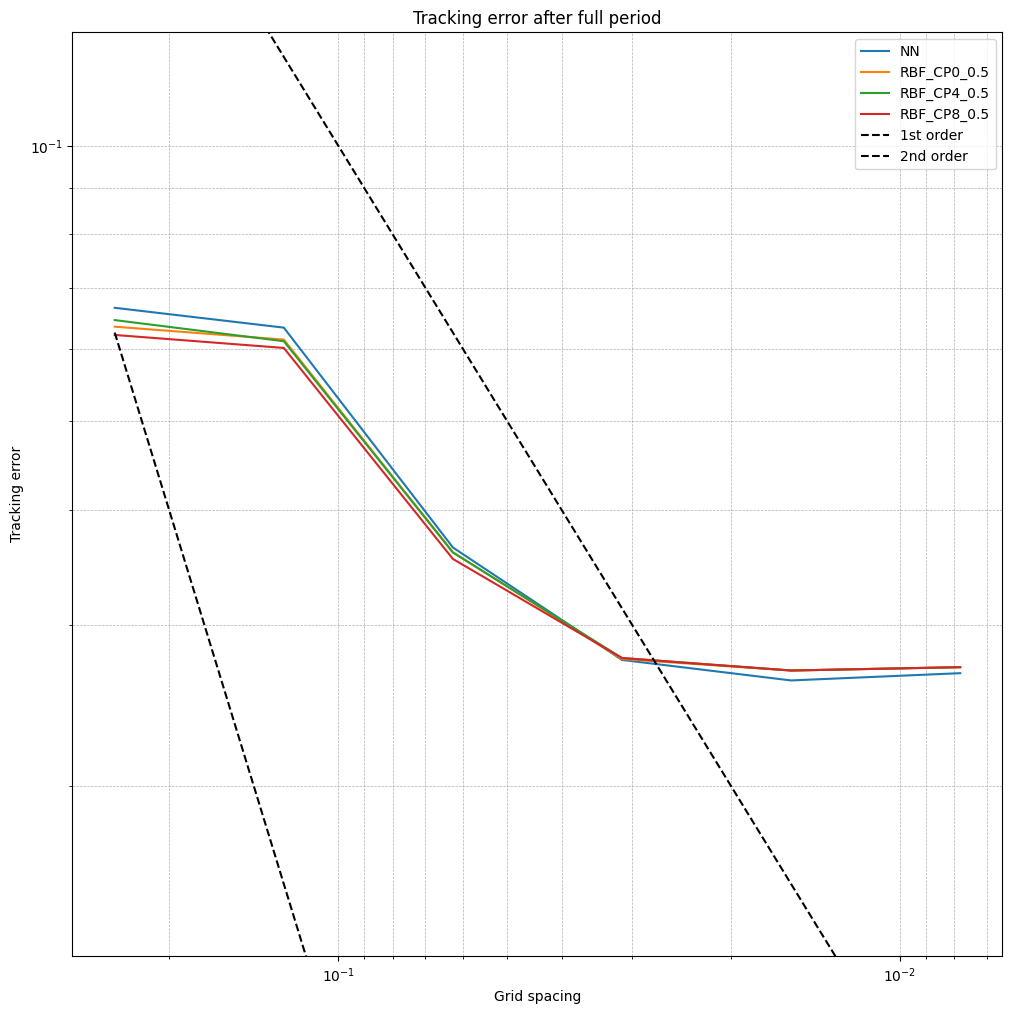

In [9]:
from matplotlib.axes import Axes


def plot_error_convergence(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Grid spacing")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Tracking error")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_convergence(df, "Tracking error after full period")


### Compare

/tmp/ipykernel_337173/2877542230.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  subplot.set_xlim(x_max, x_min)
/tmp/ipykernel_337173/2877542230.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  subplot.set_ylim(y_min, y_max)


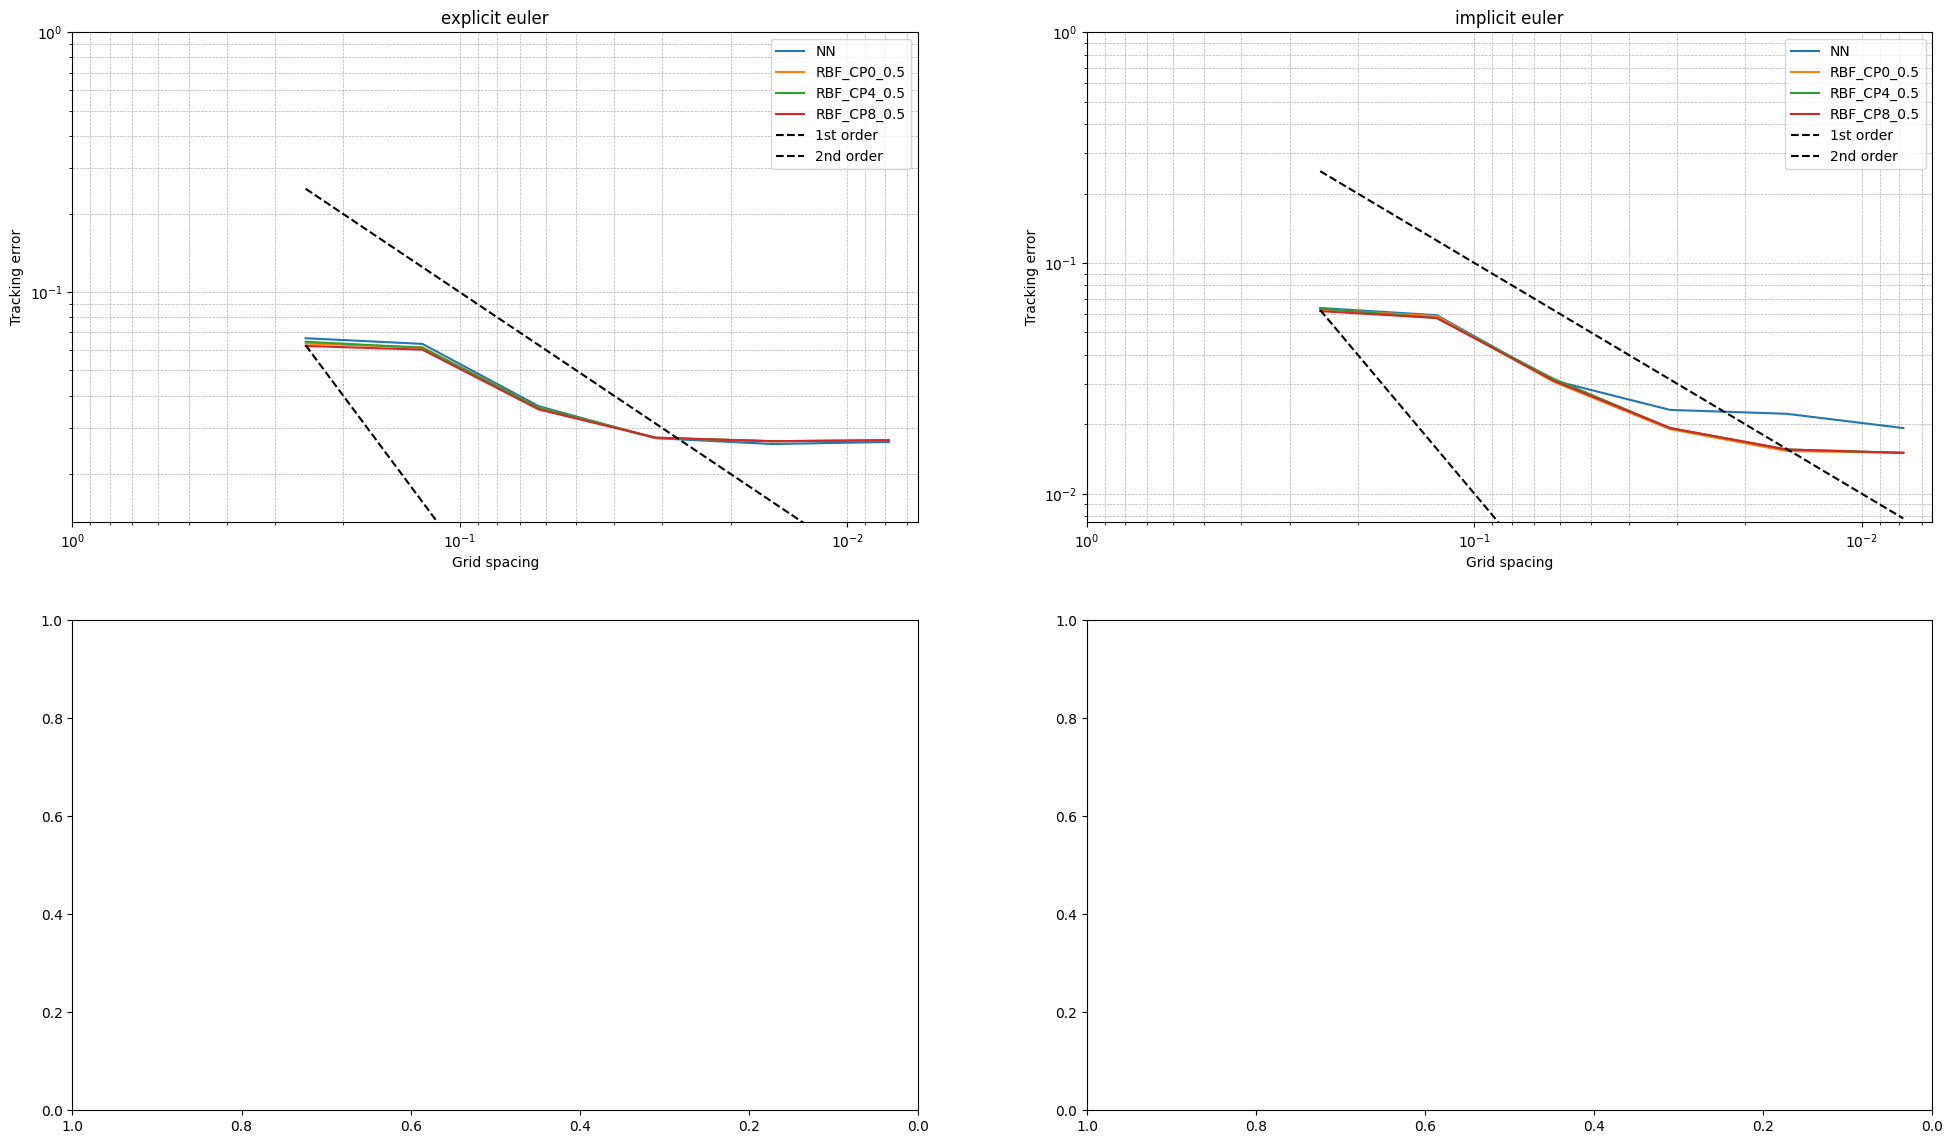

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(24, 14))

euler_explicit = load_data(working_dir.parent / "runs" / "euler_explicit")
euler_implicit = load_data(working_dir.parent / "runs" / "euler_implicit")
# trapezoidal = load_data(working_dir.parent / "runs" / "trapezoidal")

plot_error_convergence(
    euler_explicit,
    title="explicit euler",
    ax=ax[0][0],
)
plot_error_convergence(
    euler_implicit,
    title="implicit euler",
    ax=ax[0][1],
)
# plot_error_convergence(
#     trapezoidal,
#     title="trapezoidal",
#     ax=ax[1][0],
# )

# Calculate global y-axis limits
x_min = min(subplot.get_xlim()[0] for row in ax for subplot in row)
x_max = max(subplot.get_xlim()[1] for row in ax for subplot in row)
y_min = min(subplot.get_ylim()[0] for row in ax for subplot in row)
y_max = max(subplot.get_ylim()[1] for row in ax for subplot in row)

# Set the same x-axis and y-axis limits for all subplots
for row in ax:
    for subplot in row:
        subplot.set_xlim(x_max, x_min)
        subplot.set_ylim(y_min, y_max)
